In [5]:
!pip3 install opencv-python
!pip install pandas

You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [3]:
# frames in our sequences
# one sequence is for example one day that they went to record images 
# then, the sequence 00 is the first sequence they recorded. In the folder called
# image_0 you can see pairs of images from left camera and right camera.
# to know the number of frames of one sequence, we load all the images from left camera in sequence 00
# then, the total number of images is the number of frames.
file_path = "./dataset/sequences/00/image_0/"
left_images = os.listdir(file_path)
type(left_images)

list

In [4]:
left_images[:5]

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']

In [5]:
len(left_images) # this is the number of frames from left camera in sequence 00

4541

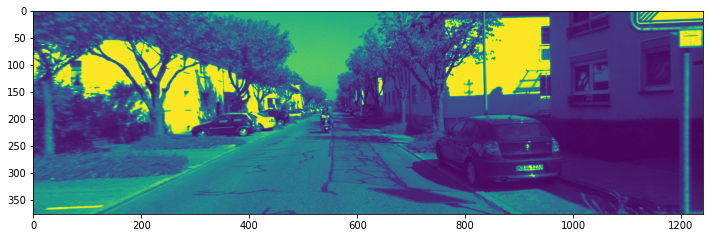

In [6]:
# load and show one image in grayscale
plt.figure(figsize=(12, 4))
plt.imshow(cv2.imread(file_path + left_images[0], 0))

In [7]:
first_image = cv2.imread(file_path + left_images[0], 0)
first_image.shape

(376, 1241)

In [8]:
# let's create our class to load the dataset
class Dataset_Handler():
    
    
    def __init__(self, sequence, lidar=False, low_memory=False):
        
        self.lidar = lidar # i don't want to use lidar if it is not mandatory.
        self.low_memory = low_memory
        # path to sequence and poses directories
        self.seq_dir = "./dataset/sequences/{}/".format(sequence)
        self.poses_dir = "./dataset/poses/{}.txt".format(sequence)
        
        # we load all the images (paths) from left camera and right camera.
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        # self.velodynes_files = os.listdir(self.seq_dir + 'velodyne')
        self.num_frames = len(self.left_image_files)
        # self.lidar_path = self.seq_dir + 'velodyne/'
        
        # read camera poses from the dataset. In the dataset, the poses are expressed
        # in a 1x12 vector, so we have to reshape them to a 3x4 matrix.
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        self.gt = np.zeros((self.num_frames, 3, 4)) # ground truth: for each pair of images we'll have 
        # a 3x4 matrix that is the ground truth pose of the camera
        
        # we fill ground truth np array with dataset poses
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape(3,4)
        
        # we load calibration info
        calib = pd.read_csv(self.seq_dir + "calib.txt", delimiter=" ", header=None, index_col=0)
        self.P0 = np.array(calib.loc["P0:"]).reshape(3, 4)
        self.P1 = np.array(calib.loc["P1:"]).reshape(3, 4)
        self.P2 = np.array(calib.loc["P2:"]).reshape(3, 4)
        self.P3 = np.array(calib.loc["P3:"]).reshape(3, 4)
        # self.Tr = np.array(calib.loc["Tr:"].reshape(3, 4)) # transformation from lidar 
        # coordinate system to left camera coordinate system.
        
        if low_memory:
                # load generators with images.
                self.reset_frames()
                
                # it will be useful to have one o two images already loaded to 
                # show them quickly in case we need it.
                self.first_image_left = cv2.imread(self.seq_dir + "image_0/"
                                                  + self.left_image_files[0], 0)
                self.first_image_right = cv2.imread(self.seq_dir + "image_1/"
                                                  + self.right_image_files[0], 0)
                self.second_image_left = cv2.imread(self.seq_dir + "image_0/"
                                                  + self.left_image_files[1], 0)
                # self.first_pointcloud = np.fromfile(self.lidar_path + velodyne_files[0])
                
                # height and width
                self.imheight = self.first_image_left.shape[0]
                self.imwidth = self.first_image_left.shape[1]
                                               
                
    # using generators, we only have in memomry one element, so if we want to iterate again
    # we have to reset the generator
    def reset_frames(self):
        # here, when we create a generator, we only have the first element in memory,
        # so, creating a new one will give us the first element and we can iterate from
        # the beginning
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        # self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file,
        #                               dtype=np.float32).reshape((-1, 4))
        #                    for velodyne_file in self.velodyne_files)
        pass

In [9]:
handler = Dataset_Handler("00", low_memory=True)

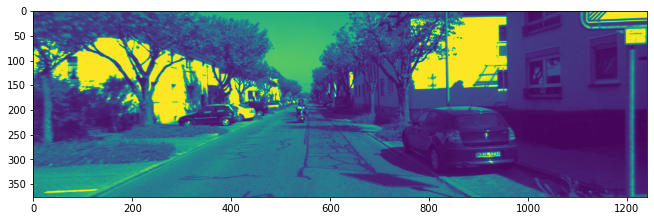

In [10]:
plt.figure(figsize=(11, 7))
plt.imshow(handler.first_image_left)

In [11]:
# we use this function to calculate the disparity using opencv functions.
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=True):
    
    # parameters for opencv disparity functions
    sad_window = 6 # sum of absolutes (images)
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size)
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 1 * block_size ** 2,
                                        P2 = 32 * 1 * block_size ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
        
    
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)
        
    return disp_left

Time to compute disparity map using StereoBM 0:00:00.011968


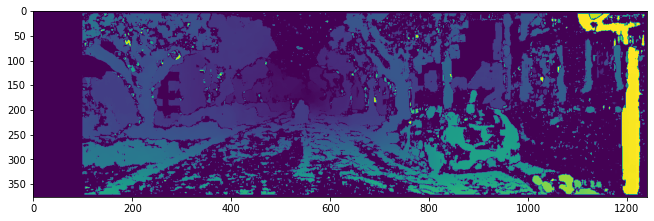

In [12]:
disp = compute_left_disparity_map(handler.first_image_left, handler.first_image_right,
                                  matcher='bm', verbose=True)
plt.figure(figsize=(11, 7))
plt.imshow(disp);
#plt.imshow(disp) # if you don't put ; at the end, matplotlib shows this message : <matplotlib.image.AxesImage at 0x2aefcf5dd68>


Time to compute disparity map using StereoSGBM 0:00:00.025962


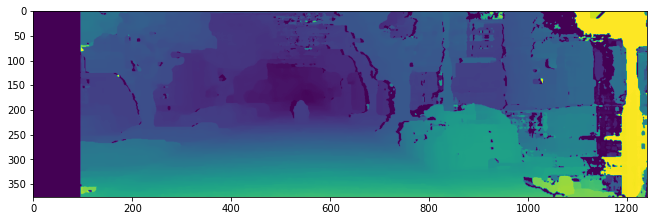

In [13]:
disp = compute_left_disparity_map(handler.first_image_left, handler.first_image_right,
                                  matcher='sgbm', verbose=True)
plt.figure(figsize=(11, 7))
plt.imshow(disp);

The rectangle at the left side is caused by the right camera. This is the space where the right camera does not see anything due to the baseline. Think that to calculate depth, we need an overlapping between the left camera and the right camera. However, there is some space in the right image that is not overlapping with the left image. This rectangle is useless. Therefore, later we will mask this part of the disparity map.

In [14]:
disp[0, 0]

-1.0

In [15]:
print(disp[disp > 0].min()) # remember this later ****
print(disp[disp > 0].max())

0.5625
95.0


In [16]:
# get intrinsic and extrinsic matrices
handler.P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [17]:
# k intrinsic, r rotation, t translation
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P1)
print(k)
print(r)
print((t/t[-1]).round(4))

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [18]:
# create our decompose function to make it easy
def decompose_projection_matrix(p):
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[-1])[:3] #we normalize t to have a 1 value in the last element, then we only get x,y,z
    
    return k, r, t

In [19]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    # we need disparity map, intrinsic matrix left camera (to get the focal value), translations
    # both in left and right camera to calculate the baseline
    # remember that calibration matrixes are rectified because they move the points from the right 
    # camera system to the left camera system, and not from the global coordinate system (here if the
    # left camera system) to the camera system.
    
    if rectified:
        # calculate baseline : x right camera minus x left camera.
        b = t_right[0] - t_left[0]
    
    else:
        # if the matrixes are not rectified, means that these matrixes move points from
        # the global coordinate system (left camera here) to the camera we're using. Then,
        # the "main" coordinate system for this opetarion is the camera's coordinate system.
        # So, we do global x minus camera x
        b = t_left[0] - t_right[0]
    
    # to calculate the focal length, we only take into account fx because we're working
    # with disparity (horizontal distances between one point seen in two images (stereo cameras))
    f = k_left[0][0]
    
    # to calculate depth, it is important to think about the minimum values of the disparity map.
    # Earlier we saw that the map has a rectangle with -1 values and, also, the map has 0 values. 
    # We don't want to divide by -1 nor 0. 
    
    # it is important to remember*** that the minimum value right after the last 0 value is 
    # 0.56... If we divide by 0, this point will not have any depth, but if we change 0 for 0.1,
    # this point will be very very far from the next further point (resulted by divided by 0.56...)
    # Therefore, when we get our depth map, we can delete those points whose depth is greater than 
    # a threshold, because we know that these points are artifacts (invented by us when dividing by
    # 0.1 instead of 0)
    disp_left[disp_left == 0.0] = 0.1
    # we do the same with -1 values
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [20]:
# decompose P0 and P1
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

In [21]:
depth_map = calc_depth_map(disp, k_left, t_left, t_right)

[[3861.44794246 3861.44794246 3861.44794246 ...    8.68961575
     8.68961575    8.68961575]
 [3861.44794246 3861.44794246 3861.44794246 ...    8.68961575
     8.68961575    8.68961575]
 [3861.44794246 3861.44794246 3861.44794246 ...    8.68961575
     8.68961575    8.68961575]
 ...
 [3861.44794246 3861.44794246 3861.44794246 ... 3861.44794246
  3861.44794246 3861.44794246]
 [3861.44794246 3861.44794246 3861.44794246 ... 3861.44794246
  3861.44794246 3861.44794246]
 [3861.44794246 3861.44794246 3861.44794246 ... 3861.44794246
  3861.44794246 3861.44794246]]


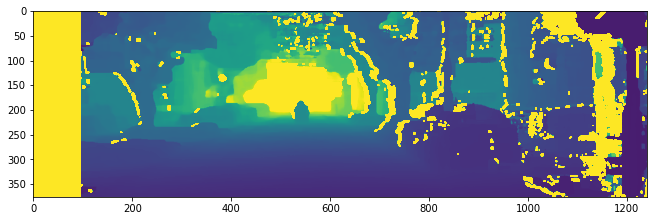

In [22]:
plt.figure(figsize=(11, 7))
print(depth_map)
# i'm using vmin and vmax to limit values and see the depth map more clear 
plt.imshow(depth_map, vmin=0, vmax=50);

Ok, we see here nothing really haha. Yellow colour is the points that we mentioned before: artifacts. These points are really far away from the camera. 

In [23]:
depth_map.max()

3861.447942459941

In [24]:
from jupyterthemes import jtplot
jtplot.style()

(array([406059.,    636.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  59921.]),
 array([   4.06468211,  389.80300814,  775.54133418, 1161.27966021,
        1547.01798625, 1932.75631228, 2318.49463832, 2704.23296435,
        3089.97129039, 3475.70961642, 3861.44794246]),
 <BarContainer object of 10 artists>)

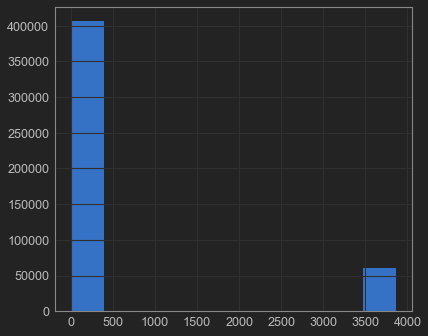

In [25]:
# if we show an histogram of our depth map, we can see that we have a lot of space between
# near and far points. Then, we can eliminate further points.
plt.hist(depth_map.flatten())

In [26]:
# here we see that all the yellow points have the same value: depth_map.max(). So, if we take only 
# nearest points, we get that the maximum value now is 686 meters.
depth_map[depth_map < depth_map.max()].flatten().max()

686.4796444444443

In [27]:
# we want to calculate the size of the yellow rectangle and create a mask of this size
for i, pixel in enumerate(depth_map[0]):
    # delete pixels with max value
    if pixel < depth_map.max():
        # here we know that all the pixels with this value are useless
        print('first non-max value at index: ', i)
        break

first non-max value at index:  96


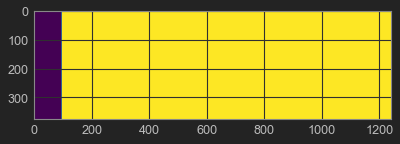

In [28]:
# we use cv2 to make a mask
mask = np.zeros(depth_map.shape, dtype=np.uint8)
ymax = depth_map.shape[0]
xmax = depth_map.shape[1]
cv2.rectangle(mask, (96, 0), (xmax, ymax), (255), thickness=-1)
plt.imshow(mask);

In [29]:
type(mask)

numpy.ndarray

In [30]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False,
                  rectified=True):
    # compute disparity map
    disp = compute_left_disparity_map(img_left,
                                      img_right,
                                      matcher=matcher,
                                      rgb=rgb,
                                      verbose=verbose)
    # decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    
    # calculate depth for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

Time to compute disparity map using StereoSGBM 0:00:00.035931


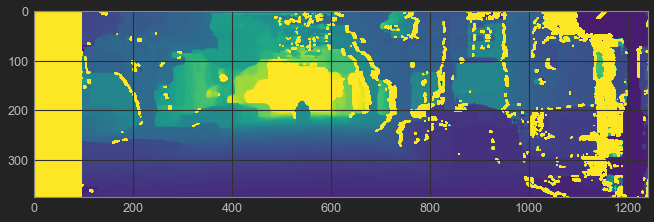

In [31]:
# test function
depth = stereo_2_depth(handler.first_image_left,
                       handler.first_image_right,
                       handler.P0,
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)

plt.figure(figsize=(11, 7))
plt.imshow(depth, vmin=0, vmax=50);

In [32]:
# FEATURE DETECTION AND MATCHING WITH SIFT

In [33]:
 def extract_features(image, detector='sift', mask=None):
        
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create(nfeatures=2000)
            
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [34]:
def match_features(des1, des2, matching='BF', detector='sift', sort=False, k=2):
    
    # brutal force
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False) # l2 is euclidean distance
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
    
    # using kdtrees (it is supposed to be faster, at least in higher dimensionalities)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    # k is the number of returned matches. We use k=2 because we want to calculate the ratio 
    # between the distance of these two matches. Then if the ratio is below a certain value, 
    # we'll discard these matches. We do this because we want our match to have a larger distance 
    # compared with the second best match, to ensure that we're getting the best possible matches.
    matches = matcher.knnMatch(des1, des2, k=k)
        
    if sort:
        matches = sorted(matches, key=lambda x: x[0].distance)
        
    return matches

In [35]:
def visualize_matches(image1, kp1, image2, kp2, match):
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16,6), dpi=100)
    plt.imshow(image_matches)

In [36]:
import datetime

In [37]:
# Then if the ratio is below a certain value, 
# we'll discard these matches. We do this because we want our match to have a larger distance 
# compared with the second best match, to ensure that we're getting the best possible matches.
def filter_matches_distance(matches, dist_threshold=0.5):
    filtered_matches = []
    # m, n are the two best matches
    for m, n in matches:
        # lowe ratio test (search on google)
        if m.distance <= dist_threshold * n.distance:
            filtered_matches.append(m)
            
    return filtered_matches

Number of matches before filtering:  2931
Number of matches after filtering:  445
Time to match and filter:  0:00:00.224370


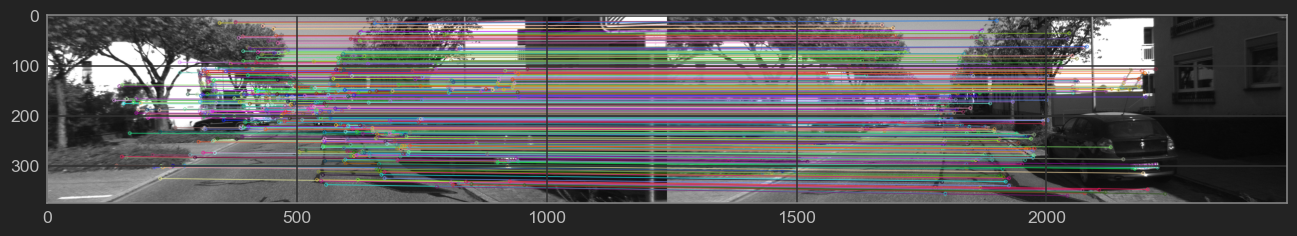

In [38]:
# WITH SIFT
# extract feature from both images
image_left = handler.first_image_left
image_right = handler.first_image_right

image_left_plus1 = handler.second_image_left

start = datetime.datetime.now()

kp0, des0 = extract_features(image_left, 'sift', mask)
kp1, des1 = extract_features(image_left_plus1, 'sift', mask)

matches = match_features(des0, des1, matching='BF', detector='sift')
print("Number of matches before filtering: ", len(matches))
matches = filter_matches_distance(matches, 0.3)
print("Number of matches after filtering: ", len(matches))

end = datetime.datetime.now()

print("Time to match and filter: ", end-start)

visualize_matches(image_left, kp0, image_left_plus1, kp1, matches)

Number of matches before filtering:  2000
Number of matches after filtering:  374
Time to match and filter:  0:00:02.045431


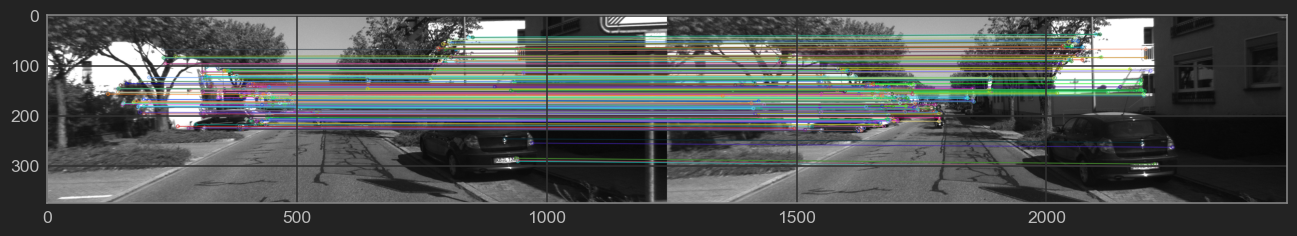

In [39]:
# WITH ORB
# extract feature from both images
image_left = handler.first_image_left
image_right = handler.first_image_right

image_left_plus1 = handler.second_image_left

start = datetime.datetime.now()

kp0, des0 = extract_features(image_left, 'orb', mask)
kp1, des1 = extract_features(image_left_plus1, 'orb', mask)

matches = match_features(des0, des1, matching='BF', detector='orb')
print("Number of matches before filtering: ", len(matches))
matches = filter_matches_distance(matches, 0.5)
print("Number of matches after filtering: ", len(matches))

end = datetime.datetime.now()

print("Time to match and filter: ", end-start)

visualize_matches(image_left, kp0, image_left_plus1, kp1, matches)

In [40]:
# Estimate motion with SolvePnPRansac

In [41]:
def estimate_motion(matches, kp1, kp2, k, depth1, max_depth=3000):
    # k is the intrinsic matrix
    # max_depth=3000m, see the blue histogram above
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    # queryIdx is the first image, trainIdx is the second (opencv called it like this)
    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    # print(image1_points)
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])
    # print(image2_points[0])
    # reproject 2d points back to 3d space
    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    
    # 3d locations of the features that we're tracking
    object_points = np.zeros((0, 3))
    # here we save the features that have bad depth values to delete them later
    delete = []
    
    # opencv uses pixels as x,y but numpy goes like y,x. That's why we index v first, then u
    # to get the depth value.
    for i, (u, v) in enumerate(image1_points):
        
        z = depth1[int(round(v)), int(round(u))]
        
        # delete features with depth values greater than max_depth (3000)
        if z > max_depth:
            delete.append(i)
            continue
        
        # applying the inverse process, from 3d to 2d you multipliy by k,
        # now is inversed k
        x = z * (u - cx) / fx
        y = z * (v - cy) / fy
        
        # now we have x, y, z in meters in the coordinate system of the camera
        object_points = np.vstack([object_points, np.array([x, y, z])])
        
    # now, we delete
    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    
    # we don't pass any coeff because in kitti dataset, we suppose that the cameras are calibrated
    # already with the chessboard thing.
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    # rotation vector to rotation matrix
    rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points

In [42]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)
k

array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])

In [43]:
rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, k, depth)
print("Rotation Matrix: ")
print(rmat)
print("Translation Vec: ")
print(tvec)

Rotation Matrix: 
[[ 0.99998918  0.00333686  0.00324138]
 [-0.00334298  0.99999264  0.00188385]
 [-0.00323507 -0.00189466  0.99999297]]
Translation Vec: 
[[ 0.0045004 ]
 [ 0.00852204]
 [-0.65727233]]


In [44]:
# this is the transformation matrix from the camera pose of the first frame to the second
transformation_matrix = np.hstack(([rmat, tvec]))
print(transformation_matrix.round(4))

[[ 1.      0.0033  0.0032  0.0045]
 [-0.0033  1.      0.0019  0.0085]
 [-0.0032 -0.0019  1.     -0.6573]]


In [45]:
# compare with the ground truth camera pose of the second frame

# it is different because we have calculated the transformation from first frame to second, and 
# in kitty dataset they calculated from the second to the first

print(handler.gt[1].round(4))

[[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


In [46]:
hom_trans_mat = np.eye(4)
hom_trans_mat

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [47]:
hom_trans_mat[:3, :3] = rmat
hom_trans_mat[:3, 3] = tvec.T
hom_trans_mat.round(4)

array([[ 1.    ,  0.0033,  0.0032,  0.0045],
       [-0.0033,  1.    ,  0.0019,  0.0085],
       [-0.0032, -0.0019,  1.    , -0.6573],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [48]:
np.linalg.inv(hom_trans_mat).round(4)

array([[ 1.    , -0.0033, -0.0032, -0.0066],
       [ 0.0033,  1.    , -0.0019, -0.0098],
       [ 0.0032,  0.0019,  1.    ,  0.6572],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [49]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None,
                   stereo_matcher='sgbm', mask=None, subset=None, plot=False):
    
    #report methods being used to user
    print("Generating disparities with Stereo{}".format(str.upper(stereo_matcher)))
    print("Detecting features with {} and matching with {}".format(str.upper(detector), 
                                                                  matching))
    
    if filter_match_distance is not None:
        print("Filtering features matches at threshold of {}*distance".format(filter_match_distance))
        
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
    
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # stablish homogeneous transformation matrix. First pose is identity
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imhegith = handler.imheight
    imwidth = handler.imwidth
    
    
    # decompose left camera projection matrix to get intrinsin k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
        
        
    # iterate through all frame at the sequence
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        
        if handler.low_memory:
            image_left = image_plus1
            image_plus1 = next(handler.images_left)
            image_right = next(handler.images_right)
        else:
            image_left = handler.images_left[i]
            image_plus1 = handler.images_left[i+1]
            image_right = handler.images_right[i]
        
        
        depth = stereo_2_depth(image_left,
                               image_right,
                               P0=handler.P0,
                               P1=handler.P1,
                               matcher=stereo_matcher,
                              )

        # get keypoints and descriptor for left image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)

        # get matches between features detected in two subsequent frames
        matches_unfilt = match_features(des0,
                                        des1,
                                        matching=matching,
                                        detector=detector
                                       )

        # filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt


        # estimate motion between sequential frames of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
                                                               kp0,
                                                               kp1,
                                                               k_left,
                                                               depth
                                                              )

        # create a blank homogeneour transformation matrix because we need to invert the matrix
        # and we can't invert a 3x4 matrix, only square matrx
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T

        # do this operation to calculate the transformation from actual frame to the origin
        # of the coordinate system (first image)
        T_tot = T_tot.dot(np.linalg.inv(Tmat))

        trajectory[i+1, :, :] = T_tot[:3, :]

        end = datetime.datetime.now()
        print("Time to compute frame {}: ".format(i+1), end-start)

        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]

            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)

    if plot:
        plt.close()
        
    return trajectory
        

In [50]:
%matplotlib qt

In [51]:
trajectory_test = visual_odometry(handler, 
                                  detector='sift',
                                  matching='BF',
                                  filter_match_distance=0.3,
                                  mask=mask,
                                  subset=None,
                                  plot=True
                                 )

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering features matches at threshold of 0.3*distance
Time to compute frame 1:  0:00:00.215447
Time to compute frame 2:  0:00:00.214731
Time to compute frame 3:  0:00:00.221479
Time to compute frame 4:  0:00:00.249395
Time to compute frame 5:  0:00:00.234417
Time to compute frame 6:  0:00:00.223445
Time to compute frame 7:  0:00:00.243882
Time to compute frame 8:  0:00:00.255508
Time to compute frame 9:  0:00:00.240858
Time to compute frame 10:  0:00:00.221250
Time to compute frame 11:  0:00:00.220589
Time to compute frame 12:  0:00:00.244410
Time to compute frame 13:  0:00:00.208617
Time to compute frame 14:  0:00:00.230698
Time to compute frame 15:  0:00:00.205839
Time to compute frame 16:  0:00:00.216260
Time to compute frame 17:  0:00:00.205655
Time to compute frame 18:  0:00:00.208839
Time to compute frame 19:  0:00:00.209862
Time to compute frame 20:  0:00:00.228368
Time to compute frame 21

Time to compute frame 191:  0:00:00.216271
Time to compute frame 192:  0:00:00.195521
Time to compute frame 193:  0:00:00.216493
Time to compute frame 194:  0:00:00.196755
Time to compute frame 195:  0:00:00.197594
Time to compute frame 196:  0:00:00.212139
Time to compute frame 197:  0:00:00.222170
Time to compute frame 198:  0:00:00.188157
Time to compute frame 199:  0:00:00.195690
Time to compute frame 200:  0:00:00.196313
Time to compute frame 201:  0:00:00.210315
Time to compute frame 202:  0:00:00.197180
Time to compute frame 203:  0:00:00.204604
Time to compute frame 204:  0:00:00.193666
Time to compute frame 205:  0:00:00.225955
Time to compute frame 206:  0:00:00.191184
Time to compute frame 207:  0:00:00.185608
Time to compute frame 208:  0:00:00.196048
Time to compute frame 209:  0:00:00.210334
Time to compute frame 210:  0:00:00.185919
Time to compute frame 211:  0:00:00.184506
Time to compute frame 212:  0:00:00.181581
Time to compute frame 213:  0:00:00.210558
Time to com

Time to compute frame 382:  0:00:00.183294
Time to compute frame 383:  0:00:00.177557
Time to compute frame 384:  0:00:00.196276
Time to compute frame 385:  0:00:00.176554
Time to compute frame 386:  0:00:00.172507
Time to compute frame 387:  0:00:00.189495
Time to compute frame 388:  0:00:00.206991
Time to compute frame 389:  0:00:00.175167
Time to compute frame 390:  0:00:00.171920
Time to compute frame 391:  0:00:00.184470
Time to compute frame 392:  0:00:00.217718
Time to compute frame 393:  0:00:00.193807
Time to compute frame 394:  0:00:00.187142
Time to compute frame 395:  0:00:00.175805
Time to compute frame 396:  0:00:00.173584
Time to compute frame 397:  0:00:00.165606
Time to compute frame 398:  0:00:00.167035
Time to compute frame 399:  0:00:00.184696
Time to compute frame 400:  0:00:00.178292
Time to compute frame 401:  0:00:00.166442
Time to compute frame 402:  0:00:00.174142
Time to compute frame 403:  0:00:00.176329
Time to compute frame 404:  0:00:00.174505
Time to com

Time to compute frame 573:  0:00:00.205680
Time to compute frame 574:  0:00:00.194087
Time to compute frame 575:  0:00:00.217077
Time to compute frame 576:  0:00:00.207544
Time to compute frame 577:  0:00:00.198931
Time to compute frame 578:  0:00:00.211008
Time to compute frame 579:  0:00:00.219761
Time to compute frame 580:  0:00:00.201414
Time to compute frame 581:  0:00:00.213039
Time to compute frame 582:  0:00:00.211505
Time to compute frame 583:  0:00:00.213353
Time to compute frame 584:  0:00:00.216621
Time to compute frame 585:  0:00:00.224799
Time to compute frame 586:  0:00:00.204187
Time to compute frame 587:  0:00:00.217181
Time to compute frame 588:  0:00:00.197965
Time to compute frame 589:  0:00:00.204592
Time to compute frame 590:  0:00:00.211661
Time to compute frame 591:  0:00:00.216875
Time to compute frame 592:  0:00:00.202301
Time to compute frame 593:  0:00:00.216896
Time to compute frame 594:  0:00:00.201892
Time to compute frame 595:  0:00:00.202458
Time to com

Time to compute frame 764:  0:00:00.237816
Time to compute frame 765:  0:00:00.246500
Time to compute frame 766:  0:00:00.233123
Time to compute frame 767:  0:00:00.230410
Time to compute frame 768:  0:00:00.225142
Time to compute frame 769:  0:00:00.220693
Time to compute frame 770:  0:00:00.242005
Time to compute frame 771:  0:00:00.217839
Time to compute frame 772:  0:00:00.228418
Time to compute frame 773:  0:00:00.238361
Time to compute frame 774:  0:00:00.259816
Time to compute frame 775:  0:00:00.261442
Time to compute frame 776:  0:00:00.242915
Time to compute frame 777:  0:00:00.240711
Time to compute frame 778:  0:00:00.232741
Time to compute frame 779:  0:00:00.239834
Time to compute frame 780:  0:00:00.246899
Time to compute frame 781:  0:00:00.232146
Time to compute frame 782:  0:00:00.240880
Time to compute frame 783:  0:00:00.215428
Time to compute frame 784:  0:00:00.224519
Time to compute frame 785:  0:00:00.226994
Time to compute frame 786:  0:00:00.232426
Time to com

Time to compute frame 955:  0:00:00.263025
Time to compute frame 956:  0:00:00.259392
Time to compute frame 957:  0:00:00.255404
Time to compute frame 958:  0:00:00.242818
Time to compute frame 959:  0:00:00.235224
Time to compute frame 960:  0:00:00.220412
Time to compute frame 961:  0:00:00.223372
Time to compute frame 962:  0:00:00.229400
Time to compute frame 963:  0:00:00.229070
Time to compute frame 964:  0:00:00.225464
Time to compute frame 965:  0:00:00.220998
Time to compute frame 966:  0:00:00.229320
Time to compute frame 967:  0:00:00.210565
Time to compute frame 968:  0:00:00.212243
Time to compute frame 969:  0:00:00.210473
Time to compute frame 970:  0:00:00.209246
Time to compute frame 971:  0:00:00.212296
Time to compute frame 972:  0:00:00.204494
Time to compute frame 973:  0:00:00.212005
Time to compute frame 974:  0:00:00.206486
Time to compute frame 975:  0:00:00.209768
Time to compute frame 976:  0:00:00.205780
Time to compute frame 977:  0:00:00.193485
Time to com

Time to compute frame 1143:  0:00:00.186555
Time to compute frame 1144:  0:00:00.193488
Time to compute frame 1145:  0:00:00.204295
Time to compute frame 1146:  0:00:00.206601
Time to compute frame 1147:  0:00:00.211170
Time to compute frame 1148:  0:00:00.192911
Time to compute frame 1149:  0:00:00.195556
Time to compute frame 1150:  0:00:00.195964
Time to compute frame 1151:  0:00:00.200924
Time to compute frame 1152:  0:00:00.209010
Time to compute frame 1153:  0:00:00.205081
Time to compute frame 1154:  0:00:00.203430
Time to compute frame 1155:  0:00:00.217381
Time to compute frame 1156:  0:00:00.213721
Time to compute frame 1157:  0:00:00.219189
Time to compute frame 1158:  0:00:00.220333
Time to compute frame 1159:  0:00:00.212446
Time to compute frame 1160:  0:00:00.219061
Time to compute frame 1161:  0:00:00.215332
Time to compute frame 1162:  0:00:00.234123
Time to compute frame 1163:  0:00:00.221071
Time to compute frame 1164:  0:00:00.243645
Time to compute frame 1165:  0:0

Time to compute frame 1330:  0:00:00.223434
Time to compute frame 1331:  0:00:00.204443
Time to compute frame 1332:  0:00:00.188496
Time to compute frame 1333:  0:00:00.217445
Time to compute frame 1334:  0:00:00.206418
Time to compute frame 1335:  0:00:00.200436
Time to compute frame 1336:  0:00:00.195452
Time to compute frame 1337:  0:00:00.209438
Time to compute frame 1338:  0:00:00.203425
Time to compute frame 1339:  0:00:00.201435
Time to compute frame 1340:  0:00:00.213427
Time to compute frame 1341:  0:00:00.200492
Time to compute frame 1342:  0:00:00.209439
Time to compute frame 1343:  0:00:00.206446
Time to compute frame 1344:  0:00:00.202459
Time to compute frame 1345:  0:00:00.228390
Time to compute frame 1346:  0:00:00.197445
Time to compute frame 1347:  0:00:00.240331
Time to compute frame 1348:  0:00:00.198471
Time to compute frame 1349:  0:00:00.220386
Time to compute frame 1350:  0:00:00.196474
Time to compute frame 1351:  0:00:00.202458
Time to compute frame 1352:  0:0

Time to compute frame 1517:  0:00:00.235374
Time to compute frame 1518:  0:00:00.199438
Time to compute frame 1519:  0:00:00.231382
Time to compute frame 1520:  0:00:00.215398
Time to compute frame 1521:  0:00:00.216448
Time to compute frame 1522:  0:00:00.217444
Time to compute frame 1523:  0:00:00.209436
Time to compute frame 1524:  0:00:00.201462
Time to compute frame 1525:  0:00:00.201497
Time to compute frame 1526:  0:00:00.203430
Time to compute frame 1527:  0:00:00.208471
Time to compute frame 1528:  0:00:00.205416
Time to compute frame 1529:  0:00:00.191508
Time to compute frame 1530:  0:00:00.221382
Time to compute frame 1531:  0:00:00.213430
Time to compute frame 1532:  0:00:00.195477
Time to compute frame 1533:  0:00:00.200463
Time to compute frame 1534:  0:00:00.195504
Time to compute frame 1535:  0:00:00.206460
Time to compute frame 1536:  0:00:00.221435
Time to compute frame 1537:  0:00:00.211432
Time to compute frame 1538:  0:00:00.211462
Time to compute frame 1539:  0:0

Time to compute frame 1704:  0:00:00.195443
Time to compute frame 1705:  0:00:00.202456
Time to compute frame 1706:  0:00:00.201460
Time to compute frame 1707:  0:00:00.196449
Time to compute frame 1708:  0:00:00.219408
Time to compute frame 1709:  0:00:00.205446
Time to compute frame 1710:  0:00:00.222376
Time to compute frame 1711:  0:00:00.215424
Time to compute frame 1712:  0:00:00.213443
Time to compute frame 1713:  0:00:00.226367
Time to compute frame 1714:  0:00:00.200460
Time to compute frame 1715:  0:00:00.213401
Time to compute frame 1716:  0:00:00.297204
Time to compute frame 1717:  0:00:00.228357
Time to compute frame 1718:  0:00:00.209439
Time to compute frame 1719:  0:00:00.231384
Time to compute frame 1720:  0:00:00.221407
Time to compute frame 1721:  0:00:00.226387
Time to compute frame 1722:  0:00:00.580450
Time to compute frame 1723:  0:00:01.012267
Time to compute frame 1724:  0:00:01.271577
Time to compute frame 1725:  0:00:00.218416
Time to compute frame 1726:  0:0

Time to compute frame 1891:  0:00:00.245365
Time to compute frame 1892:  0:00:00.237365
Time to compute frame 1893:  0:00:00.250298
Time to compute frame 1894:  0:00:00.232375
Time to compute frame 1895:  0:00:00.272269
Time to compute frame 1896:  0:00:00.262302
Time to compute frame 1897:  0:00:00.249360
Time to compute frame 1898:  0:00:00.253324
Time to compute frame 1899:  0:00:00.258314
Time to compute frame 1900:  0:00:00.270248
Time to compute frame 1901:  0:00:00.283242
Time to compute frame 1902:  0:00:00.275258
Time to compute frame 1903:  0:00:00.298197
Time to compute frame 1904:  0:00:00.294213
Time to compute frame 1905:  0:00:00.302160
Time to compute frame 1906:  0:00:00.299196
Time to compute frame 1907:  0:00:00.307203
Time to compute frame 1908:  0:00:00.320110
Time to compute frame 1909:  0:00:00.320112
Time to compute frame 1910:  0:00:00.316144
Time to compute frame 1911:  0:00:00.292249
Time to compute frame 1912:  0:00:00.300172
Time to compute frame 1913:  0:0

Time to compute frame 2078:  0:00:00.284239
Time to compute frame 2079:  0:00:00.278286
Time to compute frame 2080:  0:00:00.308148
Time to compute frame 2081:  0:00:00.301195
Time to compute frame 2082:  0:00:00.298186
Time to compute frame 2083:  0:00:00.280253
Time to compute frame 2084:  0:00:00.270272
Time to compute frame 2085:  0:00:00.288255
Time to compute frame 2086:  0:00:00.318148
Time to compute frame 2087:  0:00:00.298235
Time to compute frame 2088:  0:00:00.295181
Time to compute frame 2089:  0:00:00.307179
Time to compute frame 2090:  0:00:00.360035
Time to compute frame 2091:  0:00:00.279254
Time to compute frame 2092:  0:00:00.287231
Time to compute frame 2093:  0:00:00.286201
Time to compute frame 2094:  0:00:00.303213
Time to compute frame 2095:  0:00:00.291222
Time to compute frame 2096:  0:00:00.288257
Time to compute frame 2097:  0:00:00.328091
Time to compute frame 2098:  0:00:00.266288
Time to compute frame 2099:  0:00:00.261302
Time to compute frame 2100:  0:0

Time to compute frame 2265:  0:00:00.206419
Time to compute frame 2266:  0:00:00.230384
Time to compute frame 2267:  0:00:00.235369
Time to compute frame 2268:  0:00:00.219387
Time to compute frame 2269:  0:00:00.241325
Time to compute frame 2270:  0:00:00.229385
Time to compute frame 2271:  0:00:00.228418
Time to compute frame 2272:  0:00:00.243353
Time to compute frame 2273:  0:00:00.272298
Time to compute frame 2274:  0:00:00.272245
Time to compute frame 2275:  0:00:00.286234
Time to compute frame 2276:  0:00:00.269281
Time to compute frame 2277:  0:00:00.287205
Time to compute frame 2278:  0:00:00.295214
Time to compute frame 2279:  0:00:00.267255
Time to compute frame 2280:  0:00:00.264260
Time to compute frame 2281:  0:00:00.340089
Time to compute frame 2282:  0:00:00.285238
Time to compute frame 2283:  0:00:00.273241
Time to compute frame 2284:  0:00:00.245319
Time to compute frame 2285:  0:00:00.249307
Time to compute frame 2286:  0:00:00.232354
Time to compute frame 2287:  0:0

Time to compute frame 2452:  0:00:00.187498
Time to compute frame 2453:  0:00:00.182478
Time to compute frame 2454:  0:00:00.176501
Time to compute frame 2455:  0:00:00.167552
Time to compute frame 2456:  0:00:00.172507
Time to compute frame 2457:  0:00:00.170542
Time to compute frame 2458:  0:00:00.176527
Time to compute frame 2459:  0:00:00.189505
Time to compute frame 2460:  0:00:00.178492
Time to compute frame 2461:  0:00:00.174505
Time to compute frame 2462:  0:00:00.168519
Time to compute frame 2463:  0:00:00.170516
Time to compute frame 2464:  0:00:00.177488
Time to compute frame 2465:  0:00:00.188470
Time to compute frame 2466:  0:00:00.185502
Time to compute frame 2467:  0:00:00.188495
Time to compute frame 2468:  0:00:00.176528
Time to compute frame 2469:  0:00:00.171540
Time to compute frame 2470:  0:00:00.194455
Time to compute frame 2471:  0:00:00.188496
Time to compute frame 2472:  0:00:00.175500
Time to compute frame 2473:  0:00:00.201488
Time to compute frame 2474:  0:0

Time to compute frame 2639:  0:00:00.199145
Time to compute frame 2640:  0:00:00.189143
Time to compute frame 2641:  0:00:00.196190
Time to compute frame 2642:  0:00:00.196136
Time to compute frame 2643:  0:00:00.188023
Time to compute frame 2644:  0:00:00.184185
Time to compute frame 2645:  0:00:00.194929
Time to compute frame 2646:  0:00:00.196374
Time to compute frame 2647:  0:00:00.191299
Time to compute frame 2648:  0:00:00.190432
Time to compute frame 2649:  0:00:00.191921
Time to compute frame 2650:  0:00:00.189515
Time to compute frame 2651:  0:00:00.193765
Time to compute frame 2652:  0:00:00.203803
Time to compute frame 2653:  0:00:00.207603
Time to compute frame 2654:  0:00:00.198168
Time to compute frame 2655:  0:00:00.189036
Time to compute frame 2656:  0:00:00.188048
Time to compute frame 2657:  0:00:00.191556
Time to compute frame 2658:  0:00:00.200464
Time to compute frame 2659:  0:00:00.186131
Time to compute frame 2660:  0:00:00.196083
Time to compute frame 2661:  0:0

Time to compute frame 2826:  0:00:00.227553
Time to compute frame 2827:  0:00:00.220612
Time to compute frame 2828:  0:00:00.243654
Time to compute frame 2829:  0:00:00.229596
Time to compute frame 2830:  0:00:00.234393
Time to compute frame 2831:  0:00:00.227853
Time to compute frame 2832:  0:00:00.218579
Time to compute frame 2833:  0:00:00.223372
Time to compute frame 2834:  0:00:00.232507
Time to compute frame 2835:  0:00:00.227716
Time to compute frame 2836:  0:00:00.227433
Time to compute frame 2837:  0:00:00.236409
Time to compute frame 2838:  0:00:00.244209
Time to compute frame 2839:  0:00:00.261660
Time to compute frame 2840:  0:00:00.254318
Time to compute frame 2841:  0:00:00.258695
Time to compute frame 2842:  0:00:00.264286
Time to compute frame 2843:  0:00:00.263280
Time to compute frame 2844:  0:00:00.373005
Time to compute frame 2845:  0:00:00.353668
Time to compute frame 2846:  0:09:05.192492
Time to compute frame 2847:  0:00:00.439675
Time to compute frame 2848:  0:0

Time to compute frame 3013:  0:00:00.323376
Time to compute frame 3014:  0:00:00.325262
Time to compute frame 3015:  0:00:00.310850
Time to compute frame 3016:  0:00:00.318950
Time to compute frame 3017:  0:00:00.313471
Time to compute frame 3018:  0:00:00.304100
Time to compute frame 3019:  0:00:00.310750
Time to compute frame 3020:  0:00:00.312116
Time to compute frame 3021:  0:00:00.310528
Time to compute frame 3022:  0:00:00.330565
Time to compute frame 3023:  0:00:00.331854
Time to compute frame 3024:  0:00:00.327776
Time to compute frame 3025:  0:00:00.338574
Time to compute frame 3026:  0:00:00.335181
Time to compute frame 3027:  0:00:00.342002
Time to compute frame 3028:  0:00:00.352517
Time to compute frame 3029:  0:00:00.362886
Time to compute frame 3030:  0:00:00.354933
Time to compute frame 3031:  0:00:00.344871
Time to compute frame 3032:  0:00:00.364549
Time to compute frame 3033:  0:00:00.334213
Time to compute frame 3034:  0:00:00.329005
Time to compute frame 3035:  0:0

Time to compute frame 3200:  0:00:00.294938
Time to compute frame 3201:  0:00:00.319096
Time to compute frame 3202:  0:00:00.309120
Time to compute frame 3203:  0:00:00.294189
Time to compute frame 3204:  0:00:00.290532
Time to compute frame 3205:  0:00:00.272454
Time to compute frame 3206:  0:00:00.289866
Time to compute frame 3207:  0:00:00.283432
Time to compute frame 3208:  0:00:00.283044
Time to compute frame 3209:  0:00:00.290731
Time to compute frame 3210:  0:00:00.313210
Time to compute frame 3211:  0:00:00.321402
Time to compute frame 3212:  0:00:00.309738
Time to compute frame 3213:  0:00:00.305554
Time to compute frame 3214:  0:00:00.307464
Time to compute frame 3215:  0:00:00.304224
Time to compute frame 3216:  0:00:00.299705
Time to compute frame 3217:  0:00:00.282140
Time to compute frame 3218:  0:00:00.270303
Time to compute frame 3219:  0:00:00.254300
Time to compute frame 3220:  0:00:00.264503
Time to compute frame 3221:  0:00:00.275436
Time to compute frame 3222:  0:0

Time to compute frame 3387:  0:00:00.211407
Time to compute frame 3388:  0:00:00.211434
Time to compute frame 3389:  0:00:00.207819
Time to compute frame 3390:  0:00:00.206332
Time to compute frame 3391:  0:00:00.207445
Time to compute frame 3392:  0:00:00.208416
Time to compute frame 3393:  0:00:00.205419
Time to compute frame 3394:  0:00:00.216395
Time to compute frame 3395:  0:00:00.215893
Time to compute frame 3396:  0:00:00.205451
Time to compute frame 3397:  0:00:00.213221
Time to compute frame 3398:  0:00:00.211946
Time to compute frame 3399:  0:00:00.217419
Time to compute frame 3400:  0:00:00.213430
Time to compute frame 3401:  0:00:00.224401
Time to compute frame 3402:  0:00:00.199465
Time to compute frame 3403:  0:00:00.187497
Time to compute frame 3404:  0:00:00.200435
Time to compute frame 3405:  0:00:00.215393
Time to compute frame 3406:  0:00:00.203557
Time to compute frame 3407:  0:00:00.206447
Time to compute frame 3408:  0:00:00.197470
Time to compute frame 3409:  0:0

Time to compute frame 3574:  0:00:00.261301
Time to compute frame 3575:  0:00:00.269280
Time to compute frame 3576:  0:00:00.277034
Time to compute frame 3577:  0:00:00.273317
Time to compute frame 3578:  0:00:00.275264
Time to compute frame 3579:  0:00:00.283345
Time to compute frame 3580:  0:00:00.264831
Time to compute frame 3581:  0:00:00.251331
Time to compute frame 3582:  0:00:00.267285
Time to compute frame 3583:  0:00:00.268283
Time to compute frame 3584:  0:00:00.294608
Time to compute frame 3585:  0:00:00.288258
Time to compute frame 3586:  0:00:00.284240
Time to compute frame 3587:  0:00:00.288043
Time to compute frame 3588:  0:00:00.281282
Time to compute frame 3589:  0:00:00.274268
Time to compute frame 3590:  0:00:00.287807
Time to compute frame 3591:  0:00:00.278296
Time to compute frame 3592:  0:00:00.276261
Time to compute frame 3593:  0:00:00.255342
Time to compute frame 3594:  0:00:00.262264
Time to compute frame 3595:  0:00:00.265291
Time to compute frame 3596:  0:0

Time to compute frame 3761:  0:00:00.271274
Time to compute frame 3762:  0:00:00.279256
Time to compute frame 3763:  0:00:00.270903
Time to compute frame 3764:  0:00:00.261240
Time to compute frame 3765:  0:00:00.250330
Time to compute frame 3766:  0:00:00.244347
Time to compute frame 3767:  0:00:00.245344
Time to compute frame 3768:  0:00:00.246367
Time to compute frame 3769:  0:00:00.246340
Time to compute frame 3770:  0:00:00.252325
Time to compute frame 3771:  0:00:00.249359
Time to compute frame 3772:  0:00:00.243349
Time to compute frame 3773:  0:00:00.238362
Time to compute frame 3774:  0:00:00.247852
Time to compute frame 3775:  0:00:00.238363
Time to compute frame 3776:  0:00:00.228032
Time to compute frame 3777:  0:00:00.239386
Time to compute frame 3778:  0:00:00.229360
Time to compute frame 3779:  0:00:00.230384
Time to compute frame 3780:  0:00:00.227391
Time to compute frame 3781:  0:00:00.211432
Time to compute frame 3782:  0:00:00.206138
Time to compute frame 3783:  0:0

Time to compute frame 3948:  0:00:00.520606
Time to compute frame 3949:  0:00:00.536536
Time to compute frame 3950:  0:00:00.544543
Time to compute frame 3951:  0:00:00.554490
Time to compute frame 3952:  0:00:00.551525
Time to compute frame 3953:  0:00:00.621338
Time to compute frame 3954:  0:00:00.567451
Time to compute frame 3955:  0:00:00.618345
Time to compute frame 3956:  0:00:00.590419
Time to compute frame 3957:  0:00:00.584435
Time to compute frame 3958:  0:00:00.590384
Time to compute frame 3959:  0:00:00.609899
Time to compute frame 3960:  0:00:00.621298
Time to compute frame 3961:  0:00:00.658213
Time to compute frame 3962:  0:00:00.739023
Time to compute frame 3963:  0:00:00.889622
Time to compute frame 3964:  0:00:00.770747
Time to compute frame 3965:  0:00:00.642282
Time to compute frame 3966:  0:00:00.637295
Time to compute frame 3967:  0:00:00.736032
Time to compute frame 3968:  0:00:00.574431
Time to compute frame 3969:  0:00:00.561499
Time to compute frame 3970:  0:0

Time to compute frame 4135:  0:00:00.339119
Time to compute frame 4136:  0:00:00.337073
Time to compute frame 4137:  0:00:00.344830
Time to compute frame 4138:  0:00:00.338097
Time to compute frame 4139:  0:00:00.333109
Time to compute frame 4140:  0:00:00.320044
Time to compute frame 4141:  0:00:00.347108
Time to compute frame 4142:  0:00:00.325131
Time to compute frame 4143:  0:00:00.358477
Time to compute frame 4144:  0:00:00.349280
Time to compute frame 4145:  0:00:00.336099
Time to compute frame 4146:  0:00:00.330085
Time to compute frame 4147:  0:00:00.338276
Time to compute frame 4148:  0:00:00.313190
Time to compute frame 4149:  0:00:00.283243
Time to compute frame 4150:  0:00:00.285764
Time to compute frame 4151:  0:00:00.307920
Time to compute frame 4152:  0:00:00.304187
Time to compute frame 4153:  0:00:00.308174
Time to compute frame 4154:  0:00:00.320229
Time to compute frame 4155:  0:00:00.333487
Time to compute frame 4156:  0:00:00.358069
Time to compute frame 4157:  0:0

Time to compute frame 4322:  0:00:00.321974
Time to compute frame 4323:  0:00:00.318143
Time to compute frame 4324:  0:00:00.320926
Time to compute frame 4325:  0:00:00.339067
Time to compute frame 4326:  0:00:00.340500
Time to compute frame 4327:  0:00:00.339092
Time to compute frame 4328:  0:00:00.345858
Time to compute frame 4329:  0:00:00.313164
Time to compute frame 4330:  0:00:00.331393
Time to compute frame 4331:  0:00:00.340137
Time to compute frame 4332:  0:00:00.341278
Time to compute frame 4333:  0:00:00.332112
Time to compute frame 4334:  0:00:00.344079
Time to compute frame 4335:  0:00:00.311168
Time to compute frame 4336:  0:00:00.311168
Time to compute frame 4337:  0:00:00.303332
Time to compute frame 4338:  0:00:00.293187
Time to compute frame 4339:  0:00:00.314193
Time to compute frame 4340:  0:00:00.325130
Time to compute frame 4341:  0:00:00.344208
Time to compute frame 4342:  0:00:00.366432
Time to compute frame 4343:  0:00:00.416886
Time to compute frame 4344:  0:0

KeyboardInterrupt: 

Time to compute frame 4389:  0:00:00.485702
Time to compute frame 4390:  0:00:00.462731
Time to compute frame 4391:  0:00:00.441159
Time to compute frame 4392:  0:00:00.436123
Time to compute frame 4393:  0:00:00.428195
Time to compute frame 4394:  0:00:00.410458


KeyboardInterrupt: 

Time to compute frame 4395:  0:00:00.320963
Time to compute frame 4396:  0:00:00.397076
Time to compute frame 4397:  0:00:00.371680
Time to compute frame 4398:  0:00:00.345327
Time to compute frame 4399:  0:00:00.370821
Time to compute frame 4400:  0:00:00.325395
Time to compute frame 4401:  0:00:00.341917
Time to compute frame 4402:  0:00:00.321696
Time to compute frame 4403:  0:00:00.336140


KeyboardInterrupt: 

Time to compute frame 4404:  0:00:00.298202
Time to compute frame 4405:  0:00:00.353296
Time to compute frame 4406:  0:00:00.304254
Time to compute frame 4407:  0:00:00.310622
Time to compute frame 4408:  0:00:00.320046
Time to compute frame 4409:  0:00:00.324808
Time to compute frame 4410:  0:00:00.294788
Time to compute frame 4411:  0:00:00.329708
Time to compute frame 4412:  0:00:00.312518


KeyboardInterrupt: 

Time to compute frame 4413:  0:00:00.325130
Time to compute frame 4414:  0:00:00.349241
Time to compute frame 4415:  0:00:00.317818
Time to compute frame 4416:  0:00:00.307954
Time to compute frame 4417:  0:00:00.341432
Time to compute frame 4418:  0:00:00.320621
Time to compute frame 4419:  0:00:00.304878
Time to compute frame 4420:  0:00:00.311075
Time to compute frame 4421:  0:00:00.301307
Time to compute frame 4422:  0:00:00.302022
Time to compute frame 4423:  0:00:00.295273
Time to compute frame 4424:  0:00:00.294075
Time to compute frame 4425:  0:00:00.298364
Time to compute frame 4426:  0:00:00.299875


KeyboardInterrupt: 

Time to compute frame 4427:  0:00:00.256315


KeyboardInterrupt: 

Time to compute frame 4428:  0:00:00.251318


KeyboardInterrupt: 

Time to compute frame 4429:  0:00:00.250303


KeyboardInterrupt: 

Time to compute frame 4430:  0:00:00.245030


KeyboardInterrupt: 

Time to compute frame 4431:  0:00:00.252325


KeyboardInterrupt: 

Time to compute frame 4432:  0:00:00.245316


KeyboardInterrupt: 

Time to compute frame 4433:  0:00:00.261301


KeyboardInterrupt: 

Time to compute frame 4434:  0:00:00.245344


KeyboardInterrupt: 

Time to compute frame 4435:  0:00:00.248336


KeyboardInterrupt: 

Time to compute frame 4436:  0:00:00.254444


KeyboardInterrupt: 

Time to compute frame 4437:  0:00:00.254165


KeyboardInterrupt: 

Time to compute frame 4438:  0:00:00.254320


KeyboardInterrupt: 

Time to compute frame 4439:  0:00:00.249851


KeyboardInterrupt: 

Time to compute frame 4440:  0:00:00.251393


KeyboardInterrupt: 

Time to compute frame 4441:  0:00:00.243922


KeyboardInterrupt: 

Time to compute frame 4442:  0:00:00.257832


KeyboardInterrupt: 

Time to compute frame 4443:  0:00:00.263296


KeyboardInterrupt: 

Time to compute frame 4444:  0:00:00.265969


KeyboardInterrupt: 

Time to compute frame 4445:  0:00:00.284239
Time to compute frame 4446:  0:00:00.354152
Time to compute frame 4447:  0:00:00.356047


KeyboardInterrupt: 